# Explore LIDC chest CT scans

## Setup and configuration

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import pydicom as dicom
import pylidc as pl
from tqdm import tqdm
from fastai.medical.imaging import *

In [2]:
LIDC_DIR = Path("/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/")
DICOM_DIR = LIDC_DIR / "LIDC-IDRI"

In [3]:
print(LIDC_DIR.exists())
print(DICOM_DIR.exists())

True
True


## Assemble patient list

In [4]:
patient_list= [f for f in os.listdir(DICOM_DIR) if not f.startswith('.')]
patient_list.sort()
print(len(patient_list))

1010


## Count number of series per patient

In [5]:
series_counts = [pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).count() for pid in patient_list]
pd.Series(series_counts).value_counts()

1    1002
2       8
dtype: int64

## Extract meta data from all DICOM files

In [6]:
dcms = get_dicom_files(DICOM_DIR, recurse=True)
print(len(dcms))

244527


In [48]:
dcms

(#244527) [Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-26851/3000972.000000-22902/1-1.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-001.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-002.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-003.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-004.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-005.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-006.dcm'),Path('/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LI

In [7]:
attrs = [
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'FrameOfReferenceUID',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'Manufacturer',
 'ManufacturerModelName',
 'Modality',
 'PatientID',
 'PatientPosition',
 'PatientSex',
 'PixelPaddingValue',
 'PixelRepresentation',
 'PixelSpacing',
 'RescaleIntercept',
 'RescaleSlope',
 'RotationDirection',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SliceLocation',
 'SliceThickness',
 'StudyID',
 'StudyInstanceUID',
 'WindowCenter',
 'WindowWidth',
]

In [10]:
results = []
for dcm in tqdm(dcms):
    img = dicom.dcmread(dcm)
    img_meta = {}
    for attr in attrs:
        if hasattr(img, attr):
            img_meta[attr] = getattr(img, attr)
        else:
            img_meta[attr] = None
        pxs = img.pixel_array
        img_meta["PxMean"] = np.mean(pxs)
        img_meta["PxMin"] = np.min(pxs)
        img_meta["PxMax"] = np.max(pxs)
    results.append(img_meta)

100%|██████████| 244527/244527 [2:03:35<00:00, 32.98it/s]  


In [11]:
df = pd.DataFrame(data=results)

In [12]:
df.shape

(244527, 35)

In [13]:
df.head()

,BitsAllocated,PxMean,PxMin,PxMax,BitsStored,BodyPartExamined,Columns,FrameOfReferenceUID,ImageOrientationPatient,ImagePositionPatient,...,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,SeriesNumber,SliceLocation,SliceThickness,StudyID,StudyInstanceUID,WindowCenter,WindowWidth
0,16,1274.787065,0,2121,14,CHEST,1721,1.3.6.1.4.1.14519.5.2.1.6279.6001.290742320286378838161032436197,None,None,...,1.3.6.1.4.1.14519.5.2.1.6279.6001.278396232245593731333696036781,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900213760403901722902,3000972.0,NaN,NaN,,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801102574107980626851,"[1149, 1149, 1149]","[695, 521, 1043]"
1,16,-91.907864,-2000,2607,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -9.500000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.995654199437862485099260177642,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-9.50,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0
2,16,-86.287533,-2000,2580,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -10.750000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.306789031543980493707890947898,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-10.75,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0
3,16,-80.395668,-2000,2622,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -12.000000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.193334668820347030701611993369,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-12.00,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0
4,16,-74.869011,-2000,2527,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -13.250000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.162166008518220075719972878036,1,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-13.25,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0


In [14]:
print(df.BitsStored.value_counts())
print(df.PixelRepresentation.value_counts())

16    165016
12     78976
14       510
15        16
10         9
Name: BitsStored, dtype: int64
1    165016
0     79511
Name: PixelRepresentation, dtype: int64


count    244527.000000
mean        515.414024
std          71.929356
min         512.000000
25%         512.000000
50%         512.000000
75%         512.000000
max        3000.000000
Name: Columns, dtype: float64


<AxesSubplot:>

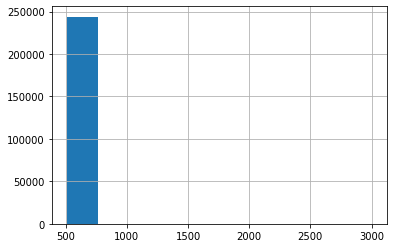

In [15]:
print(df.Columns.describe())
df.Columns.hist()

count    244527.000000
mean        515.646595
std          76.169181
min         512.000000
25%         512.000000
50%         512.000000
75%         512.000000
max        2991.000000
Name: Rows, dtype: float64


<AxesSubplot:>

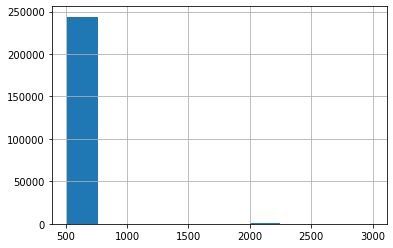

In [16]:
print(df.Rows.describe())
df.Rows.hist()

count    243958.000000
mean          1.610888
std           0.667770
min           0.600000
25%           1.250000
50%           1.250000
75%           2.000000
max           5.000000
Name: SliceThickness, dtype: float64


<AxesSubplot:>

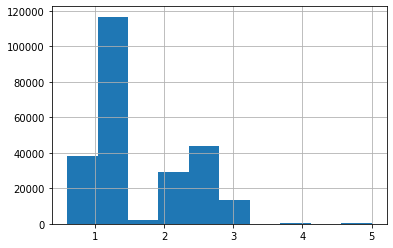

In [17]:
print(df.SliceThickness.describe())
df.SliceThickness.hist()

In [18]:
df.PixelSpacing = df.PixelSpacing.apply(lambda x: x[0] if x is not None else None)

In [37]:
df["zPos"] = df.ImagePositionPatient.apply(lambda x: x[-1] if x is not None else None)

In [50]:
df["path"] = [str(p) for p in dcms]

count    243990.000000
mean          0.681723
std           0.082773
min           0.141000
25%           0.625000
50%           0.683594
75%           0.722656
max           0.976562
Name: PixelSpacing, dtype: float64


<AxesSubplot:>

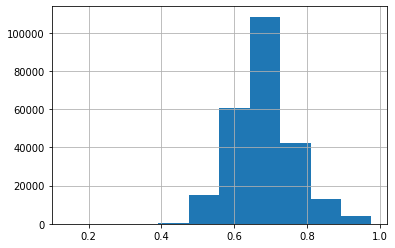

In [19]:
print(df.PixelSpacing.describe())
df.PixelSpacing.hist()

count    244527.000000
mean         14.703644
std           1.869974
min          10.000000
25%          12.000000
50%          16.000000
75%          16.000000
max          16.000000
Name: BitsStored, dtype: float64


<AxesSubplot:>

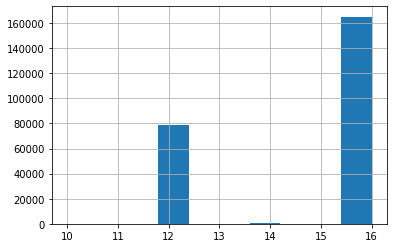

In [20]:
print(df.BitsStored.describe())
df.BitsStored.hist()

1    165016
0     79511
Name: PixelRepresentation, dtype: int64


<AxesSubplot:>

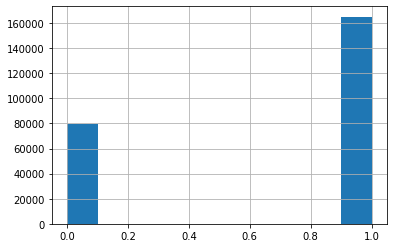

In [21]:
print(df.PixelRepresentation.value_counts())
df.PixelRepresentation.hist()

count    244471.000000
mean       -985.732754
std         188.951403
min       -1024.000000
25%       -1024.000000
50%       -1024.000000
75%       -1024.000000
max           0.000000
Name: RescaleIntercept, dtype: float64


<AxesSubplot:>

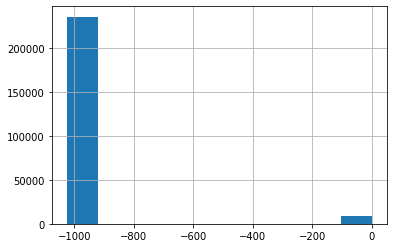

In [22]:
print(df.RescaleIntercept.describe())
df.RescaleIntercept.hist()

count    244471.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: RescaleSlope, dtype: float64


<AxesSubplot:>

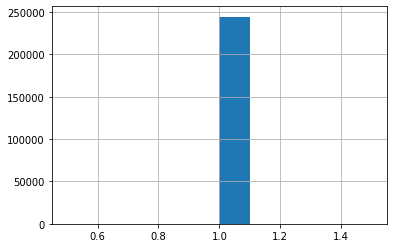

In [23]:
print(df.RescaleSlope.describe())
df.RescaleSlope.hist()

In [41]:
df.pivot_table(
    values=["PatientID", "RescaleIntercept", "PxMean", "PxMin", "PxMax", "zPos"], 
    index=["BitsStored", "PixelRepresentation"], 
    aggfunc={
        "PatientID": ["nunique", "count"], 
        "RescaleIntercept": ["min", "mean", "median", "max"],
        "PxMean": "mean",
        "PxMin": ["min", "mean", "median", "max"],
        "PxMax": "max",
        "zPos": "count",
    },
)

PatientID          PxMax        PxMean   PxMin  \
                                   count nunique    max          mean     max   
BitsStored PixelRepresentation                                                  
10         0                           9       6   1023    415.465788   126.0   
12         0                       78976     304   4095    548.627279   783.0   
14         0                         510     234  16383   6880.764948  2550.0   
15         0                          16      16  32767  16650.852709  5272.0   
16         1                      165016     730  32767     62.923317 -1024.0   

                                                             RescaleIntercept  \
                                       mean  median      min              max   
BitsStored PixelRepresentation                                                  
10         0                      14.888889     0.0      0.0              NaN   
12         0                       0.021146     0.0      0.0              0.0   
14         0                      91.988235     2.0      0.0              0.0   
15         0                     642.312500     0.0      0.0              NaN   
16         1                   -1831.921765 -2000.0 -32768.0              0.0   

                                                               zPos  
                                       mean  median     min   count  
BitsStored PixelRepresentation                                       
10         0                            NaN     NaN     NaN       0  
12         0                   -1017.709443 -1024.0 -1024.0   78942  
14         0                       0.000000     0.0     0.0       0  
15         0                            NaN     NaN     NaN       0  
16         1                    -973.481359 -1024.0 -1024.0  165016

In [52]:
df.head()

,BitsAllocated,PxMean,PxMin,PxMax,BitsStored,BodyPartExamined,Columns,FrameOfReferenceUID,ImageOrientationPatient,ImagePositionPatient,...,SeriesInstanceUID,SeriesNumber,SliceLocation,SliceThickness,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,zPos,path
0,16,1274.787065,0,2121,14,CHEST,1721,1.3.6.1.4.1.14519.5.2.1.6279.6001.290742320286378838161032436197,None,None,...,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900213760403901722902,3000972.0,NaN,NaN,,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801102574107980626851,"[1149, 1149, 1149]","[695, 521, 1043]",NaN,/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-26851/3000972.000000-22902/1-1.dcm
1,16,-91.907864,-2000,2607,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -9.500000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-9.50,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0,-9.50,/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-001.dcm
2,16,-86.287533,-2000,2580,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -10.750000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-10.75,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0,-10.75,/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-002.dcm
3,16,-80.395668,-2000,2622,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -12.000000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-12.00,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0,-12.00,/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-003.dcm
4,16,-74.869011,-2000,2527,16,CHEST,512,1.3.6.1.4.1.14519.5.2.1.6279.6001.317612173882565644891105935364,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]","[-175.500000, -174.500000, -13.250000]",...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919,3000522.0,-13.25,1.25,,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329,40.0,350.0,-13.25,/Volumes/LaCie/data/lung-cancer-detection/lidc-idri/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-98329/3000522.000000-04919/1-004.dcm


In [53]:
df.to_csv(DICOM_DIR/"lidc_dicom_meta_raw.csv", index=False)

We can remove all scans that have `BitsStored` values other than 12 or 16, because they don't contain the z coordinate that is used for ordering scans.

In [54]:
df = df.drop(df.query("(BitsStored != 12) & (BitsStored != 16)").index)
df.shape

(243992, 37)

In [55]:
df.pivot_table(
    values=["PatientID", "RescaleIntercept", "PxMean", "PxMin", "PxMax", "zPos"], 
    index=["BitsStored", "PixelRepresentation"], 
    aggfunc={
        "PatientID": ["nunique", "count"], 
        "RescaleIntercept": ["min", "mean", "median", "max"],
        "PxMean": "mean",
        "PxMin": ["min", "mean", "median", "max"],
        "PxMax": "max",
        "zPos": "count",
    },
)

PatientID          PxMax      PxMean   PxMin  \
                                   count nunique    max        mean     max   
BitsStored PixelRepresentation                                                
12         0                       78976     304   4095  548.627279   783.0   
16         1                      165016     730  32767   62.923317 -1024.0   

                                                             RescaleIntercept  \
                                       mean  median      min              max   
BitsStored PixelRepresentation                                                  
12         0                       0.021146     0.0      0.0              0.0   
16         1                   -1831.921765 -2000.0 -32768.0              0.0   

                                                               zPos  
                                       mean  median     min   count  
BitsStored PixelRepresentation                                       
12         0                   -1017.709443 -1024.0 -1024.0   78942  
16         1                    -973.481359 -1024.0 -1024.0  165016

In [60]:
print(len(pd.unique(df.PatientID)))
print(len(pd.unique(df.SeriesInstanceUID)))
print(len(pd.unique(df.StudyInstanceUID)))

1010
1052
1052


In [61]:
df.to_csv(DICOM_DIR/"lidc_dicom_meta_clean.csv", index=False)